# Welcome to the final project!
In this notebook you will be asked to use singular value decomposition and SVM to classify images. We will be working with the MNIST numbers dataset, where training data consist of pictures of digits, and the target value is the digit itself.

First, we import the necessary libraries.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

Now, we read both training and test dataset as arrays. 

In [3]:
data = np.load('mnist.npz')
X_test_total, X_train_total, y_train_total, y_test_total = data['x_test'], data['x_train'], data['y_train'], data['y_test']

Let's select two digits that we will be learning to separate, for example 3 and 8.

In [4]:
num1, num2 = 3, 8

Let us form the lists of indices i such that the target of i-th object of our training data is either num1 or num2. Do the same for the test dataset.

In [5]:
train_indx = [y == num1 or y == num2 for y in y_train_total] 
test_indx = [y == num1 or y == num2 for y in y_test_total]

Form new arrays consisting of the data with the target values num1 and num2 only. 

In [6]:
X_train, y_train = X_train_total[train_indx], y_train_total[train_indx]
X_test, y_test = X_test_total[test_indx], y_test_total[test_indx]

## Looking at the data

Let us check the sizes of the datasets and the shape of one image.

In [7]:
print('Data shapes: ')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

Data shapes: 
X_train:  (11982, 28, 28)
y_train:  (11982,)
X_test:  (1984, 28, 28)
y_test:  (1984,)


In [8]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]

n_train, n_test

(11982, 1984)

In [9]:
print('Shape of one item: ')
print(X_train[0].shape)

Shape of one item: 
(28, 28)


Train data are images of digits.

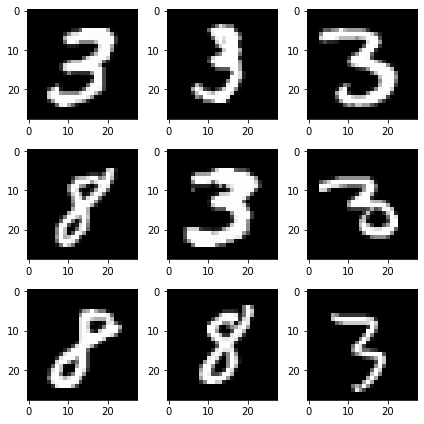

In [10]:
plt.figure(figsize=(6,6))
a, b = 3, 3
for i in range(a*b):  
    plt.subplot(b, a, i+1)
    plt.imshow(X_train[i], cmap='gray')
plt.tight_layout()
plt.show()

Target values are numbers.

In [11]:
y_train[:9]

array([3, 3, 3, 8, 3, 3, 8, 8, 3], dtype=uint8)

## Task 1 (1 point)
Now our data is 3-dimensional of shape (number of images, n_pixels, n_pixels). To work with PCA and SVM we need to flatten the images by turning each of them into an array of shape (n_pixels x n_pixels, ).

In [12]:
def flatten_image(X):
    return X.reshape(-1)

In [13]:
X_train_flat = np.array([flatten_image(img) for img in X_train])
X_test_flat = np.array([flatten_image(img) for img in X_test])
X_train_flat.shape, X_test_flat.shape

((11982, 784), (1984, 784))

PCA works best when the data is scaled (think, why?), so let's scale our data. We will use [StandartScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) for it. Note, that scaling replaces a collection of vectors x by the collection of the vectors $x' = (x-M)/D$, where $M$ is the mean vector of
the sample, $D$ is the vector of standard deviations of all components of the vectors, and the division is component-wise. So, the scaled collection has the same size as the original one, and each column has 0 mean and unit standard deviation.


In [14]:
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

## Question 1

Please write your answer on the impact of scaling below. Why does scaling help PCA? If your idea need some computer experiments for confirmation (say, training and accuracy calculations  with non-scaled data), please provide the code here as well.

***Your answer here.***

First, Principal Components rotate around the origin and find the maximum sum of squared distances, so **StandardScaler needs to centralize all variables around the origin**. Second, because Principal Components find the maximum sum of squared distances, variables with larger absolute values will dominate and contribute more to the Principal Components than variables with smaller absolute values. **By scaling the variables, we eliminate the effect of scale** on the Principal Components and ensure that all variables have the same relative importance. </br>

Let me show what happens when we don't scale variables. Imagine we research the business of 50 companies and know their market capitalization and number of employees.

In [15]:
n = 50

np.random.seed(42)
employee = np.random.randint(100, 500, n)

noise = np.random.normal(0, 1, n)
market_cap = employee * 10**(3 + noise)

X = np.vstack((employee, market_cap))

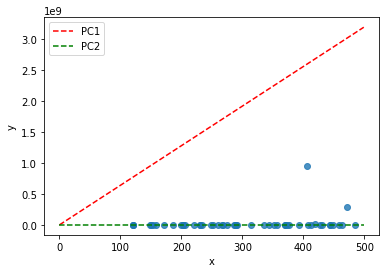

In [16]:
pca = PCA(n_components=2)
pca.fit(X.T)

k1 = pca.components_[0,1]/pca.components_[0,0]
k2 = pca.components_[1,1]/pca.components_[1,0]
x = range(0, 500)

plt.scatter(*X, alpha=.8)
plt.plot(x, k1 * x, 'r--', label='PC1')
plt.plot(x, k2 * x, 'g--', label='PC2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

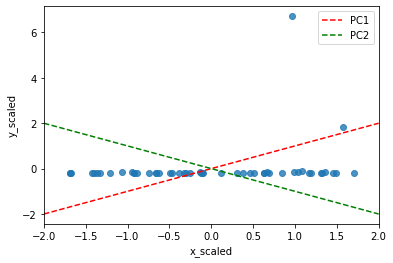

In [17]:
scaler_test = StandardScaler()
X_scaled = scaler_test.fit_transform(X.T)

pca = PCA(n_components=2)
pca.fit(X_scaled)

k1 = pca.components_[0,1]/pca.components_[0,0]
k2 = pca.components_[1,1]/pca.components_[1,0]
x = range(-2,3)

plt.scatter(*X_scaled.T, alpha=.8)
plt.plot(x, k1 * x, 'r--', label='PC1')
plt.plot(x, k2 * x, 'g--', label='PC2')
plt.xlabel('x_scaled')
plt.ylabel('y_scaled')
plt.legend()
plt.xlim(-2,2)
plt.show()

Now, we call PCA and reduce the number of components for each vector. 

In [18]:
pca = PCA(n_components=128, random_state=42)
X_train_flat = pca.fit_transform(X_train_flat)

In [19]:
X_test_flat = pca.transform(X_test_flat)

In [20]:
X_train_flat.shape, X_test_flat.shape

((11982, 128), (1984, 128))

## Question 2

What is the ratio of the memory used for the data `compressed' by PCA and the one used for the original data?

***Your answer here.***

The ratio of the memory used after PCA and the one used for the original data = $\frac{128}{784} = \frac{8}{49}$

Now, we use SVM with linear kernel to separate the two classes.

In [21]:
%%time
clf = LinearSVC(random_state=42)
clf.fit(X_train_flat, y_train) 

CPU times: user 3.6 s, sys: 59.9 ms, total: 3.66 s
Wall time: 2.78 s


LinearSVC(random_state=42)

Now, let us make the predictions and calculate the accuracy, that is, the ratio of the true predictions to the test sample size.  Use [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) as the quality metric here.

$$accuracy(y\_true, y\_pred) = \frac{1}{n}\sum_{i=1}^n [y\_true_i=y\_pred_i],$$ where $[a=b]=1$, if $a=b$, and $0$ otherwise.

In [22]:
y_pred = clf.predict(X_test_flat)
acc = np.sum(y_test == y_pred) / y_test.shape[0]
print("Test accuracy: ", acc)

Test accuracy:  0.9667338709677419


## Try it from your own input
Try to make your own dataset. You can either make a photo image of an ink-written digit or draw a digit using a graphical editor of your computer or smartphone. Note that the input picture has to be a white number on a black background, like the numbers in the MNIST dataset. It can be either in png or jpeg format. Replace the sample striwith your file name. 

In [23]:
from scipy import misc
from PIL import Image

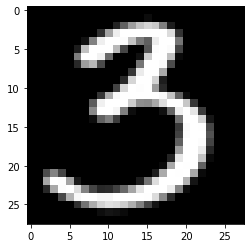

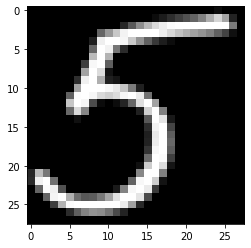

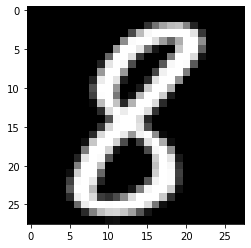

(3, 28, 28)

In [24]:
my_nums = [3, 5, 8]
custom = []

for num in my_nums:
    image = Image.open(f'MNIST/{str(num)}.jpg').convert('L')
    new_image = np.array(image.resize((28, 28)))
    new_image[new_image < 10] = 0 #making black background
    custom.append(new_image)
    plt.imshow(new_image, cmap='gray')
    plt.show()

custom = np.array(custom)
custom.shape

Re-shape your image and make a prediction. 

In [25]:
custom = [flatten_image(img) for img in custom]
custom = scaler.transform(custom)
custom = pca.transform(custom)
custom.shape

(3, 128)

In [26]:
clf.predict(custom)

array([3, 3, 3], dtype=uint8)

In [27]:
d = {}

for y in y_train:
    d[y] = d.setdefault(y, 0) + 1
d

{3: 6131, 8: 5851}

## Question 3

Repeat the above digit recognition procedure with other 5 to 10 hand-written images. Do your experiments confirm the above accuracy estimate? How do you think, why they confirm (or not confirm) it?

***Your answer here.***
We see that the model predicts all given numbers as 3, but 3, 5, 8 was given. It couldn't predict 5 because we train model on two classes - 3 and 8. But it could predict 8. I guess the model didn't recognise 8 because it's overfitted or given data was poorly processed compared to the MNIST dataset

## Task 2
Now let's try another approach explained [here](https://technodocbox.com/3D_Graphics/77509408-Handwritten-digit-classification-and-reconstruction-of-marred-images-using-singular-value-decomposition.html) in Section 3. For each digit, we create a new matrix $A$ whose columns are flattened images of this digit. The first several (say, 10) columns of the matrix $U$ from SVD decomposition of $A$ represent a collection of "typical" images of this digit. Given an unrecognized flatten image, among average typical flattened images we find the closets one. Its target value is considered as a prediction for the target of the unrecognized image.

## SVD refesher
As you may recall from the lectures, SVD of a matrix $A$ is a decomposition:
$A = U \Sigma V^T,$ where $U$ and $V$ are orthogonal matrices. In this method we will be utilizing some properties of SVD.

In [28]:
def getSingularVectorsLeft(matrix, number=10): # let's take first 10 numbers
    # return first _number_ columns of U from SVD of _matrix_
    u, s, v = svd(matrix)
    
    return u[:, :number]

In [29]:
def getSingularImage(X_train, y_train, number):
    # find images whose target is _number_
    num_idx = [y == number for y in y_train]
    select_images = X_train[num_idx]
    matrix = np.zeros((select_images.shape[1]**2,1))
    
    for image in select_images:
    # iteratively append new column to form matrix A
        matrix = np.append(matrix, image.reshape((image.shape[0]**2, 1)), axis=1)
    
    #left_basis = getSingularVectorsLeft(matrix[:, 1:])

    return getSingularVectorsLeft(matrix[:, 1:])

Try it first on "0".

In [30]:
%%time
left_basis = getSingularImage(X_train_total, y_train_total, 0)

assert left_basis.shape == (784, 10)

CPU times: user 59.9 s, sys: 47.6 s, total: 1min 47s
Wall time: 1min 32s


### Task 2.1 (1 point)
Plot first 9 singular images of the digit 0 taking columns of matrix U and reshaping them back into images 28x28. Use `numpy.reshape`.

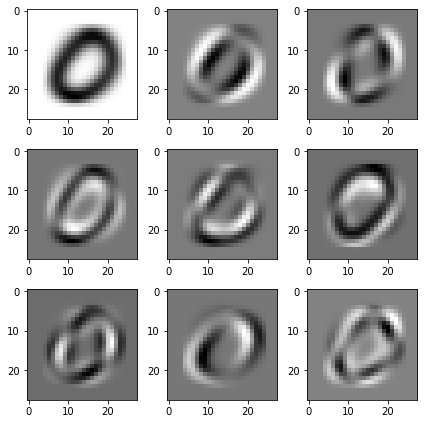

In [31]:
#singular images
plt.figure(figsize=(6,6))
a, b = 3, 3
for i in range(a*b):  
    plt.subplot(b, a, i+1)
    img = np.reshape(left_basis[:, i], (28, 28)) # ith element of left basis reshaped back to 28x28
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

## Question 4

Reflect on properties of the columns of $U_k$. What properties do you think are contained in each of them? Draw more singular images to help you make conclusions.

***Your answer here.***

The columns of $U_k$ contain the most significant features and patterns in the image in decresing order, since the eigenvectors in $U_k$ are arrange in order from the largest to the smallest eigenvalue in $\Sigma$.

Now let's move on and obtain singular images for all numbers. The matrices $U_k$ from  [the article](https://technodocbox.com/3D_Graphics/77509408-Handwritten-digit-classification-and-reconstruction-of-marred-images-using-singular-value-decomposition.html) are represented as `number_basis_matrices[k]`.
This might take a while to finish, feel free to add debug print in your function to know the progress.

In [32]:
%%time
number_basis_matrices = [getSingularImage(X_train_total, y_train_total, i) for i in range(10)]

CPU times: user 9min 25s, sys: 7min 32s, total: 16min 57s
Wall time: 14min 36s


### Task 2.2 (1 point)
Plot the first singular image of each digit, similarly to the previous task.

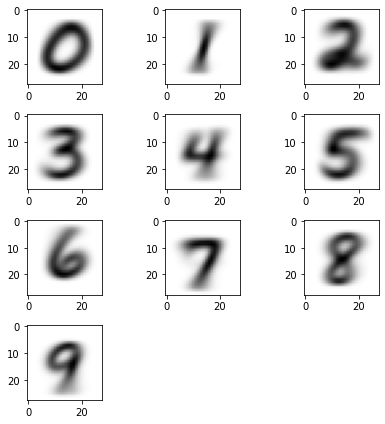

In [33]:
plt.figure(figsize=(6,6))
a, b = 3, 4
for i in range(10):  
    plt.subplot(b, a, i+1)
    img = np.reshape(number_basis_matrices[i][:, 0], (28, 28))
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

In [34]:
dim = number_basis_matrices[0].shape[0]
dim

784

### Task 2.3 (1.5 points)

Here we calculate the new projection matrix for each $U_k$ to apply later in testing:
$pr = (I - U_k \cdot U_{k}^{T})$. Use `numpy.matmul` for matrix multiplication and `numpy.identity` to create an identity matrix. Please note that this operation might also take some time to finish.

In [35]:
%%time
numeric_values = [
    np.identity(number_basis_matrices[i].shape[0]) - np.matmul(
        number_basis_matrices[i],
        number_basis_matrices[i].T
    )
    for i in range(10)
]

CPU times: user 147 ms, sys: 43 ms, total: 190 ms
Wall time: 33.8 ms


### Task 2.4 (1.5 points)
Implement function utilizing `numeric_values` matrices to predict labels for unknown images. Use `numpy.norm` and enumerate to iterate over numeric values.

In [36]:
numeric_values[0].shape

(784, 784)

In [37]:
def find_closest(test_value, numeric_values):
    stacked_test = test_value.reshape(-1, 1)
    target = -1
    min_dist = np.inf
    
    for i, matrix in enumerate(numeric_values):
        dist = np.linalg.norm(matrix @ stacked_test)
        
        if dist < min_dist:
            min_dist = dist
            target = i
            
    return target

In [38]:
%%time
y_pred = [find_closest(test_value, numeric_values) for test_value in X_test]

CPU times: user 32.3 s, sys: 208 ms, total: 32.5 s
Wall time: 5.44 s


In [39]:
acc = accuracy_score(y_test, y_pred)
acc

0.9304435483870968

## Additional task (2 points)
In the first task we trained Linear SVM to separate 3s and 8s. Here you can implement multiclass classification for _all_ numbers in `MNIST`. Use the same function LinearSVC for “one-vs-the-rest” multi-class strategy, see [the documentation](https://scikit-learn.org/stable/modules/svm.html#classification).  Follow the same steps from task 1: scaling, feature selection, training and testing. Is the accuracy of this method greater then the one calculated above?

**Note:** Use `random_state=42` for `PCA` and `LinearSVC`. Training `LinearSVC` on all the data might take a while, that's normal.

In [42]:
%%time
#flatting
print('Flatting')
X_train_flat = np.array([flatten_image(img) for img in X_train_total])
X_test_flat = np.array([flatten_image(img) for img in X_test_total])
print('X_train_flat shape:', X_train_flat.shape, '\nX_test_flat shape:', X_test_flat.shape)

#scaling
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

#PCA
print('\nStarting PCA')
pca = PCA(n_components=128, random_state=42)
X_train_flat = pca.fit_transform(X_train_flat)
X_test_flat = pca.transform(X_test_flat)
print('After PCA')
print('X_train_flat shape:', X_train_flat.shape, '\nX_test_flat shape:', X_test_flat.shape)

#Fitting model
print('\nFitting model')
clf = LinearSVC(random_state=42)
clf.fit(X_train_flat, y_train_total) 

#Predicting
y_pred = clf.predict(X_test_flat)

Flatting
X_train_flat shape: (60000, 784) 
X_test_flat shape: (10000, 784)
Starting PCA
After PCA
X_train_flat shape: (60000, 128) 
X_test_flat shape: (10000, 128)
Fitting model
CPU times: user 2min 58s, sys: 1.45 s, total: 2min 59s
Wall time: 2min 50s


In [43]:
acc = accuracy_score(y_test_total, y_pred)
print("Test accuracy: ", acc)

Test accuracy:  0.9079


Accuracy of LinearSVC lower than accuracy obtained SVD, but LinearSVC fits much more faster.